In [2]:
import numpy as numpy
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
df = pd.read_csv('kgh_d.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1386 non-null   object 
 1   Open        1386 non-null   float64
 2   Najwyzszy   1386 non-null   float64
 3   Najnizszy   1386 non-null   float64
 4   Zamkniecie  1386 non-null   float64
 5   Wolumen     1386 non-null   float64
dtypes: float64(5), object(1)
memory usage: 65.1+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2019-07-10 00:00:00'), Timestamp('2025-01-23 00:00:00'))

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], linestyle='-', color='blue', label='Cena otwarcia')
plt.title('Cena otwarcia akcji KGHM w czasie', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Cena otwarcia (PLN)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()


output_path = 'KGHM_Open_Price_Plot.png'

plt.savefig(output_path, format='png')
plt.close()



In [7]:
import numpy as np

# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()

# Check for negative values in numeric columns
negative_values = {col: (df[col] < 0).sum() for col in df.select_dtypes(include=[np.number])}

# Check for outliers using the IQR method
outlier_bounds = {}
for col in ['Open']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_bounds[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound, 'outliers': outliers}

# Check for irregular sampling intervals
timestamp_differences = df['Date'].diff().dt.total_seconds().dropna()
irregular_intervals = not np.allclose(timestamp_differences, timestamp_differences.median())

# Output the results
quality_results = {
    "missing_values": missing_values.to_dict(),
    "duplicates": duplicates,
    "negative_values": negative_values,
    "outlier_bounds": outlier_bounds,
    "irregular_sampling_intervals": irregular_intervals,
}

print("Data Quality Results:")
for key, value in quality_results.items():
    print(f"{key}: {value}")


Data Quality Results:
missing_values: {'Date': 0, 'Open': 0, 'Najwyzszy': 0, 'Najnizszy': 0, 'Zamkniecie': 0, 'Wolumen': 0}
duplicates: 0
negative_values: {'Open': np.int64(0), 'Najwyzszy': np.int64(0), 'Najnizszy': np.int64(0), 'Zamkniecie': np.int64(0), 'Wolumen': np.int64(0)}
outlier_bounds: {'Open': {'lower_bound': np.float64(46.45249999999998), 'upper_bound': np.float64(207.30850000000004), 'outliers': np.int64(4)}}
irregular_sampling_intervals: True


In [8]:
h_max = 50
x=df['Open'].values
acf_emp = acf(x, fft=True, nlags=h_max)
pacf_emp = pacf(x, nlags=h_max, method='yw')

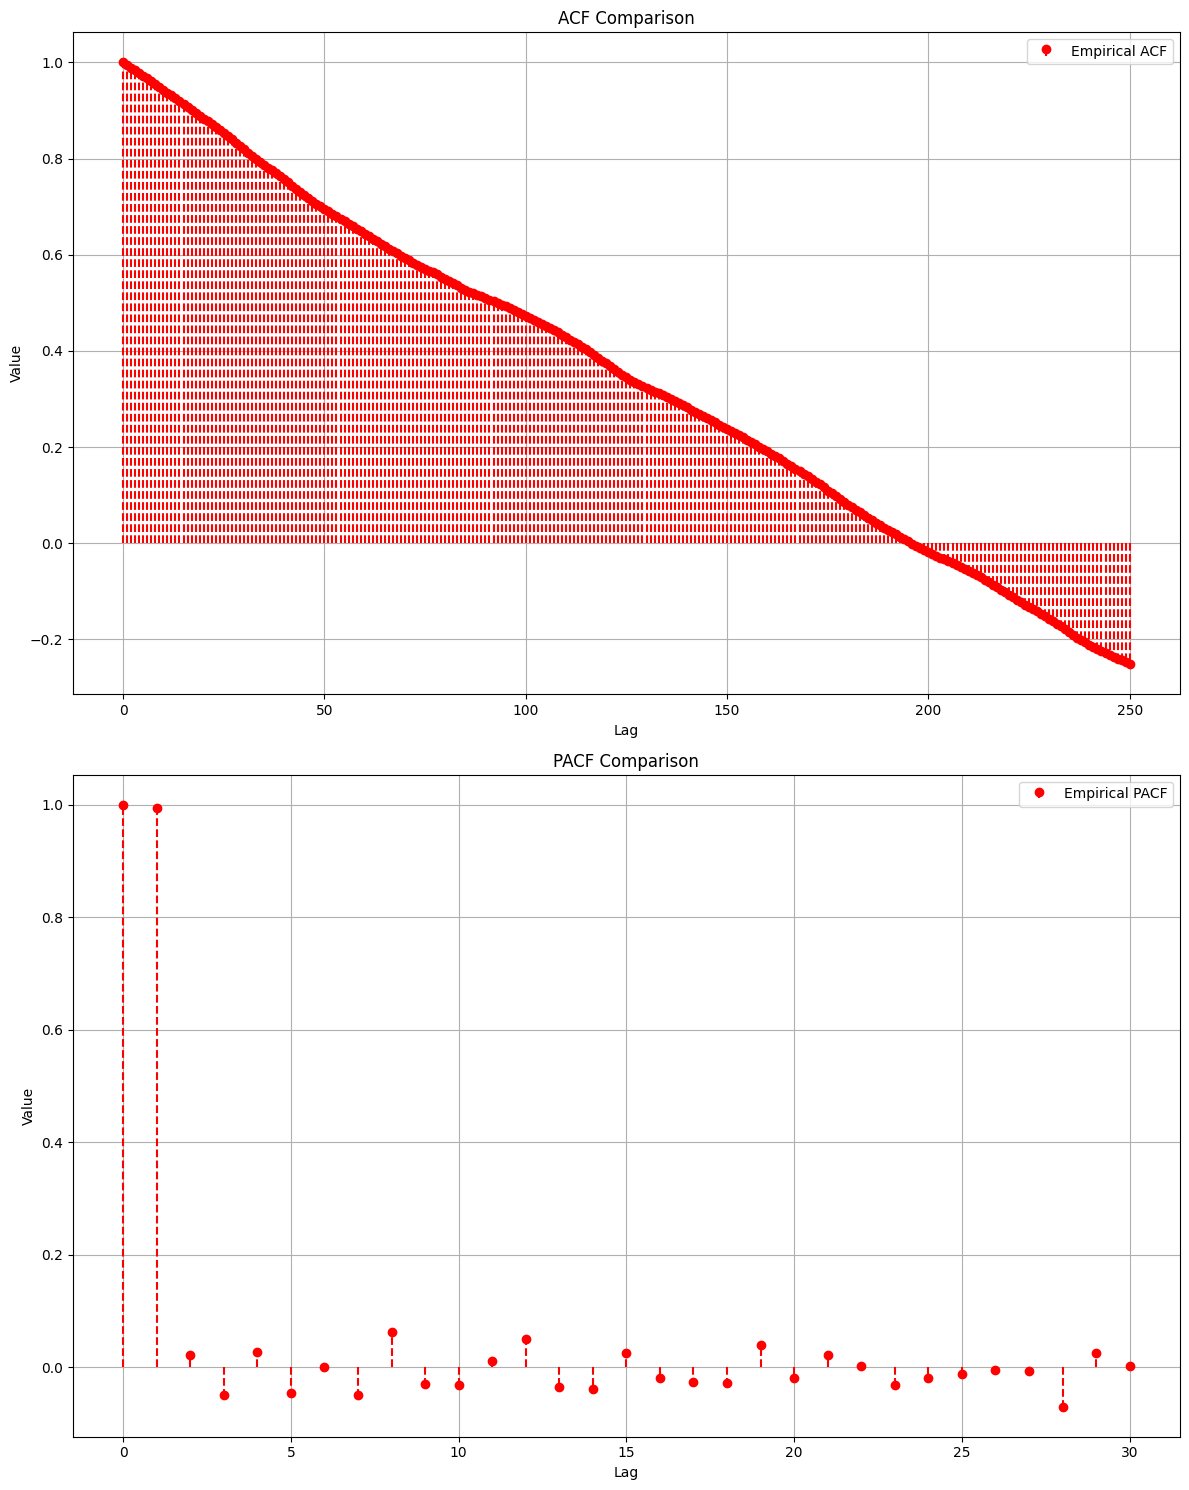

In [9]:
# Wyciągnięcie wartości czasowych
values = df['Open'].values

# Obliczanie empirycznych ACF, ACVF i PACF
empirical_acf = acf(values, fft=True, nlags=250)
# empirical_acvf = acovf(values, fft=True)
empirical_pacf = pacf(values, nlags=30)

# Tworzenie wykresów
fig, axs = plt.subplots(2, 1, figsize=(12, 15))

# ACF
# axs[0].stem(range(len(theoretical_acf)), theoretical_acf, linefmt='b-', markerfmt='bo', basefmt=' ', label='Theoretical ACF')
axs[0].stem(range(len(empirical_acf)), empirical_acf, linefmt='r--', markerfmt='ro', basefmt=' ', label='Empirical ACF')
axs[0].set_title('ACF Comparison')
axs[0].legend()

# # ACVF
# # axs[1].stem(range(len(theoretical_acvf)), theoretical_acvf, linefmt='b-', markerfmt='bo', basefmt=' ', label='Theoretical ACVF')
# axs[1].stem(range(len(empirical_acvf)), empirical_acvf, linefmt='r--', markerfmt='ro', basefmt=' ', label='Empirical ACVF')
# axs[1].set_title('ACVF Comparison')
# axs[1].legend()

# PACF
# axs[2].stem(range(len(theoretical_pacf)), theoretical_pacf, linefmt='b-', markerfmt='bo', basefmt=' ', label='Theoretical PACF')
axs[1].stem(range(len(empirical_pacf)), empirical_pacf, linefmt='r--', markerfmt='ro', basefmt=' ' ,label='Empirical PACF')
axs[1].set_title('PACF Comparison')
axs[1].legend()

# Ustawienia wspólne dla wszystkich wykresów
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('ACF_ACVF_PACF_Comparison.png', format='png')

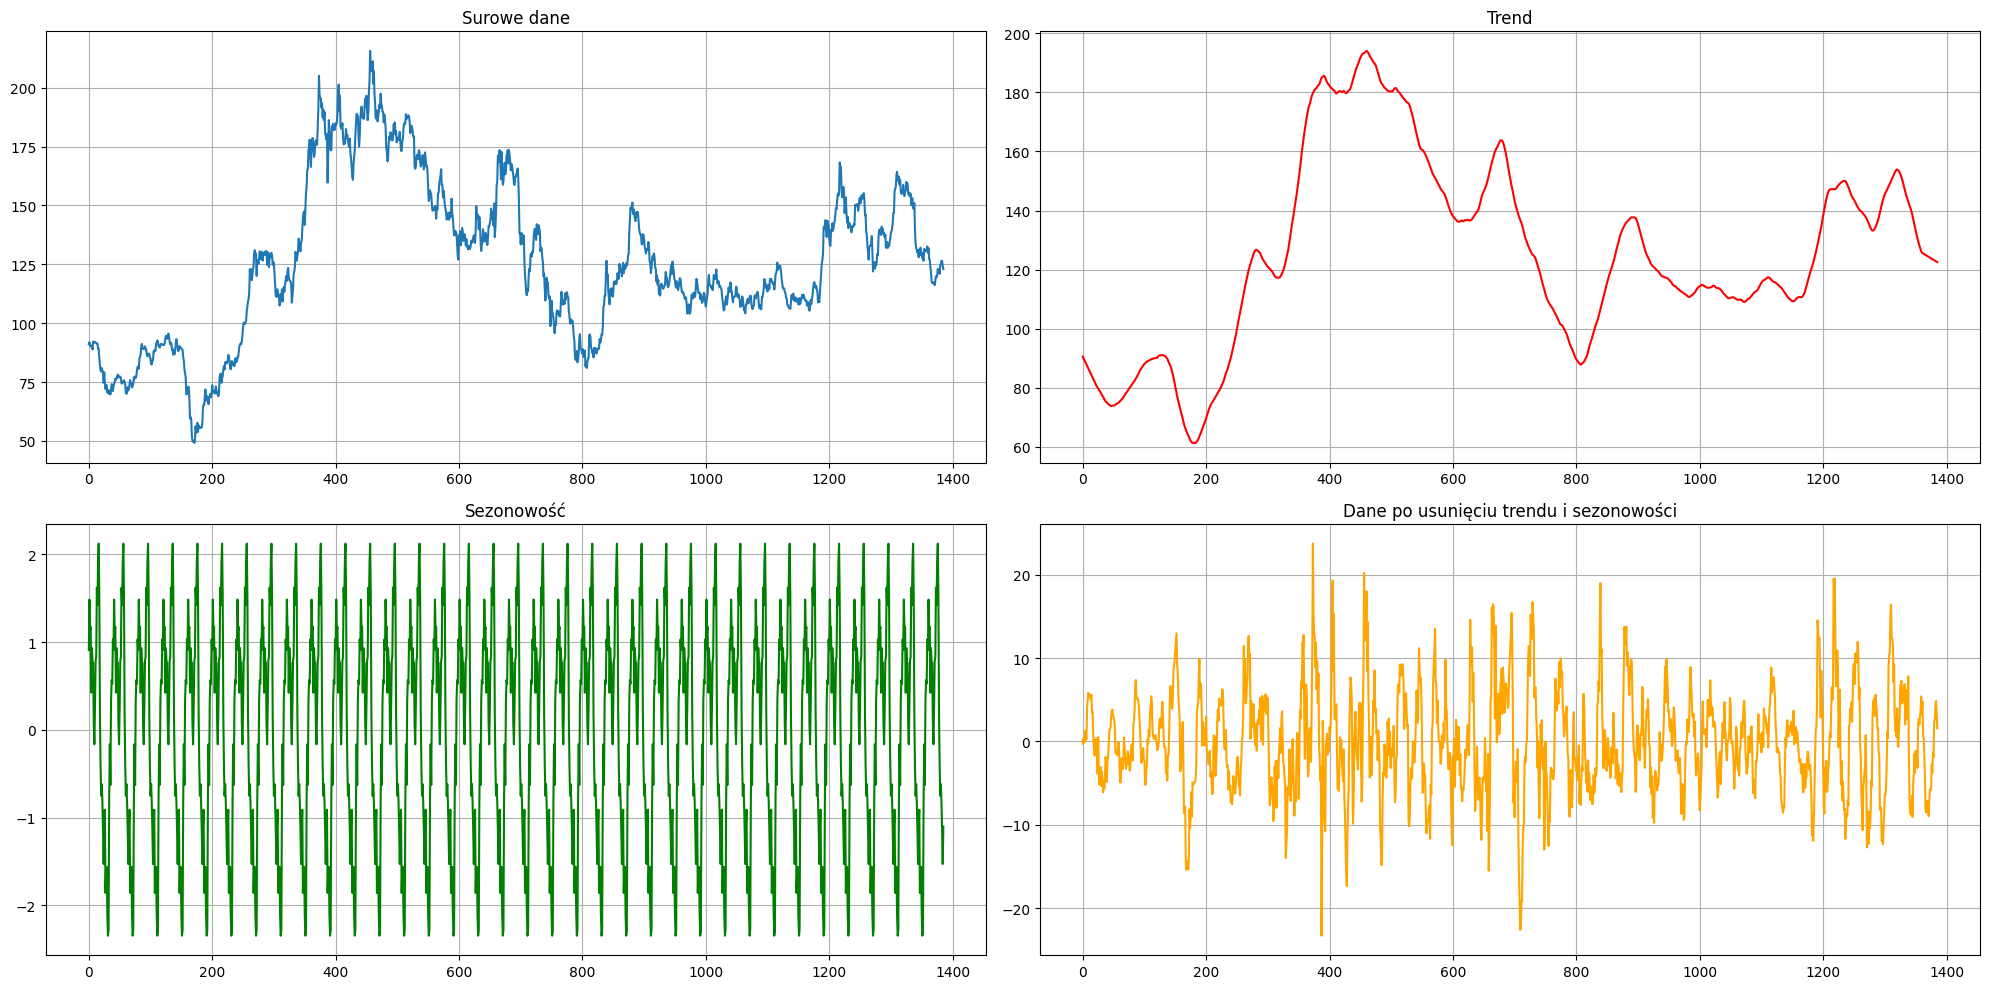

In [10]:
decomposition = seasonal_decompose(x, model='additive', period=40, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(x, label='Original')
plt.grid(True)
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.grid(True)
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.grid(True)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.grid(True)
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
# plt.show()
plt.savefig('Seasonal_Decomposition.png', format='png')

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

def fit_arma_model_and_save_coefficients(time_series, max_p=5, max_q=5, ic='aic'):
    """
    Dopasowuje model ARMA do szeregu czasowego, zapisuje współczynniki AR i MA i je wyświetla.
    
    Parameters:
        time_series (array-like): Szereg czasowy wejściowy.
        max_p (int): Maksymalny rząd dla części AR.
        max_q (int): Maksymalny rząd dla części MA.
        ic (str): Kryterium informacyjne ('aic').
    
    Returns:
        dict: Słownik zawierający współczynniki AR i MA oraz podsumowanie modelu.
    """
    # Sprawdzenie stacjonarności szeregu
    result = adfuller(time_series)
    if result[1] > 0.05:
        raise ValueError("Szereg czasowy nie jest stacjonarny. Użyj różnicowania przed dopasowaniem modelu ARMA.")
    
    # Wyznaczenie najlepszego modelu ARMA
    try:
        best_order = arma_order_select_ic(time_series, max_ar=max_p, max_ma=max_q, ic=ic)['aic_min_order']
        model = ARIMA(time_series, order=(best_order[0], 0, best_order[1])).fit()

        # Pobranie współczynników AR i MA
        ar_coefficients = model.arparams if hasattr(model, 'arparams') else []
        ma_coefficients = model.maparams if hasattr(model, 'maparams') else []

        # Zapisanie współczynników w słowniku
        coefficients = {
            "AR_coefficients": ar_coefficients,
            "MA_coefficients": ma_coefficients,
            "model_summary": model.summary()
        }

        # Wyświetlenie współczynników
        print("Współczynniki AR:", ar_coefficients)
        print("Współczynniki MA:", ma_coefficients)
        
        return coefficients
    except Exception as e:
        print(f"Nie udało się dopasować modelu ARMA: {e}")
        return None

# Przykład użycia
if __name__ == "__main__":
    # Przykładowy szereg czasowy (podmień na swoje dane)
    n = 100
    time_series = residual

    # Próbujemy dopasować model ARMA i zapisać współczynniki
    try:
        coefficients = fit_arma_model_and_save_coefficients(time_series)
        if coefficients:
            print("\nPodsumowanie modelu:\n", coefficients["model_summary"])
    except ValueError as e:
        None
        
coefficients1 = fit_arma_model_and_save_coefficients(time_series) 
p = coefficients.get("AR_coefficients", [])
q = coefficients.get("MA_coefficients", [])
p,q
        

/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

Współczynniki AR: [ 0.7479788   0.03571994  0.39319555  0.42719341 -0.66104509]
Współczynniki MA: [ 0.07908412  0.08981772 -0.42443913 -0.74294202]

Podsumowanie modelu:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1386
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -3519.757
Date:                Sun, 26 Jan 2025   AIC                           7061.515
Time:                        00:00:22   BIC                           7119.091
Sample:                             0   HQIC                          7083.049
                               - 1386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.016      0

/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

Współczynniki AR: [ 0.7479788   0.03571994  0.39319555  0.42719341 -0.66104509]
Współczynniki MA: [ 0.07908412  0.08981772 -0.42443913 -0.74294202]


/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(array([ 0.7479788 ,  0.03571994,  0.39319555,  0.42719341, -0.66104509]),
 array([ 0.07908412,  0.08981772, -0.42443913, -0.74294202]))

In [12]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")
        
adfuller_test(residual)


Statystyka testowa = -11.158, p-Value = 0.0 => Stationary. 


In [13]:
import matplotlib.pyplot as plt

def plot_ar_ma_coefficients(coefficients, true_params=None):
    """
    Rysuje wykres współczynników AR i MA na podstawie wyników modelu ARMA.
    
    Parameters:
        coefficients (dict): Słownik zawierający współczynniki AR i MA.
    """
    ar_coefficients = coefficients.get("AR_coefficients", [])
    ma_coefficients = coefficients.get("MA_coefficients", [])
    
    # Połącz współczynniki AR i MA w jedną listę
    estimated_params = list(ar_coefficients) + list(ma_coefficients)
    
    # Ustawienia wykresu
    plt.figure(figsize=(8, 3))


    # Współczynniki estymowane
    plt.plot(estimated_params, 's', markersize=8, alpha=0.5, label='Estymowana')

    # Konfiguracja wykresu
    plt.legend()
    plt.xlabel('Parametr')
    plt.ylabel('Wartość parametru')
    plt.title('Porównanie parametrów')
    plt.xticks(range(len(estimated_params)), 
               [f'$\phi_{i+1}$' for i in range(len(ar_coefficients))] +
               [f'$\Theta_{i+1}$' for i in range(len(ma_coefficients))])
    plt.show()

# Przykład użycia
if __name__ == "__main__":
    # Symulowane prawdziwe współczynniki (opcjonalnie do porównania)  

    # Dopasowanie modelu ARMA i rysowanie wykresu
    try:
        coefficients = fit_arma_model_and_save_coefficients(time_series)
        if coefficients:
            plot_ar_ma_coefficients(coefficients, true_params=true_params)
    except ValueError as e:
        None

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\T'
/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_1749/3767554139.py:29: SyntaxWarning: invalid escape sequence '\p'
  [f'$\phi_{i+1}$' for i in range(len(ar_coefficients))] +
/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_1749/3767554139.py:30: SyntaxWarning: invalid escape sequence '\T'
  [f'$\Theta_{i+1}$' for i in range(len(ma_coefficients))])
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarnin

Współczynniki AR: [ 0.7479788   0.03571994  0.39319555  0.42719341 -0.66104509]
Współczynniki MA: [ 0.07908412  0.08981772 -0.42443913 -0.74294202]


/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_1749/3767554139.py:29: SyntaxWarning: invalid escape sequence '\p'
  [f'$\phi_{i+1}$' for i in range(len(ar_coefficients))] +
/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_1749/3767554139.py:30: SyntaxWarning: invalid escape sequence '\T'
  [f'$\Theta_{i+1}$' for i in range(len(ma_coefficients))])


NameError: name 'true_params' is not defined

In [14]:

p1=len(p)
q1=len(q)
model_first_method = ARIMA(residual, order=(p1, 0, q1)).fit(method='statespace')
model_second_method = ARIMA(residual, order=(p1, 0, q1)).fit(method='innovations_mle')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())


/Users/karolcieslik/Documents/VS/Raport_Kaszcz/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1386
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -3519.757
Date:                Sun, 26 Jan 2025   AIC                           7061.515
Time:                        00:01:36   BIC                           7119.091
Sample:                             0   HQIC                          7083.049
                               - 1386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.016      0.390      0.696      -0.025       0.037
ar.L1          0.7480      0.127      5.905      0.000       0.500       0.996
ar.L2          0.03

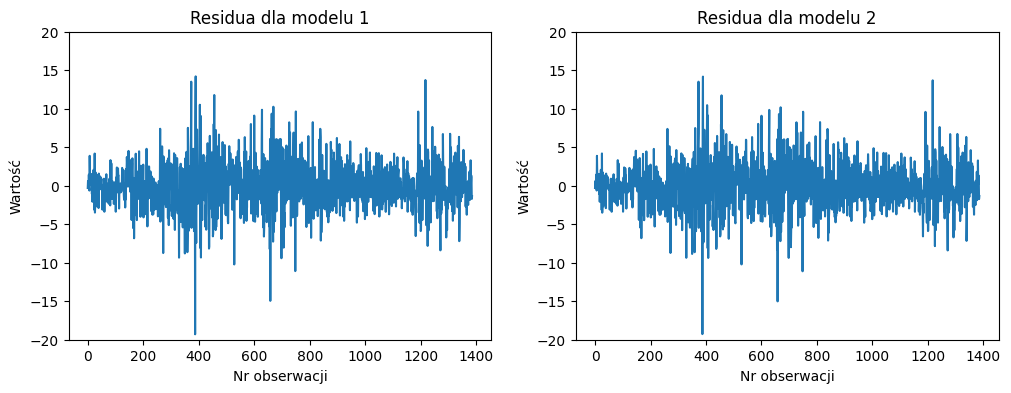

In [15]:
resid_normal = model_first_method.resid

redid_normal2 = model_second_method.resid


# Plot the residuals
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resid_normal)
plt.title('Residua dla modelu 1')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-20, 20])

plt.subplot(1, 2, 2)
plt.plot(redid_normal2)
plt.title('Residua dla modelu 2')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.ylim([-20, 20])

plt.show()

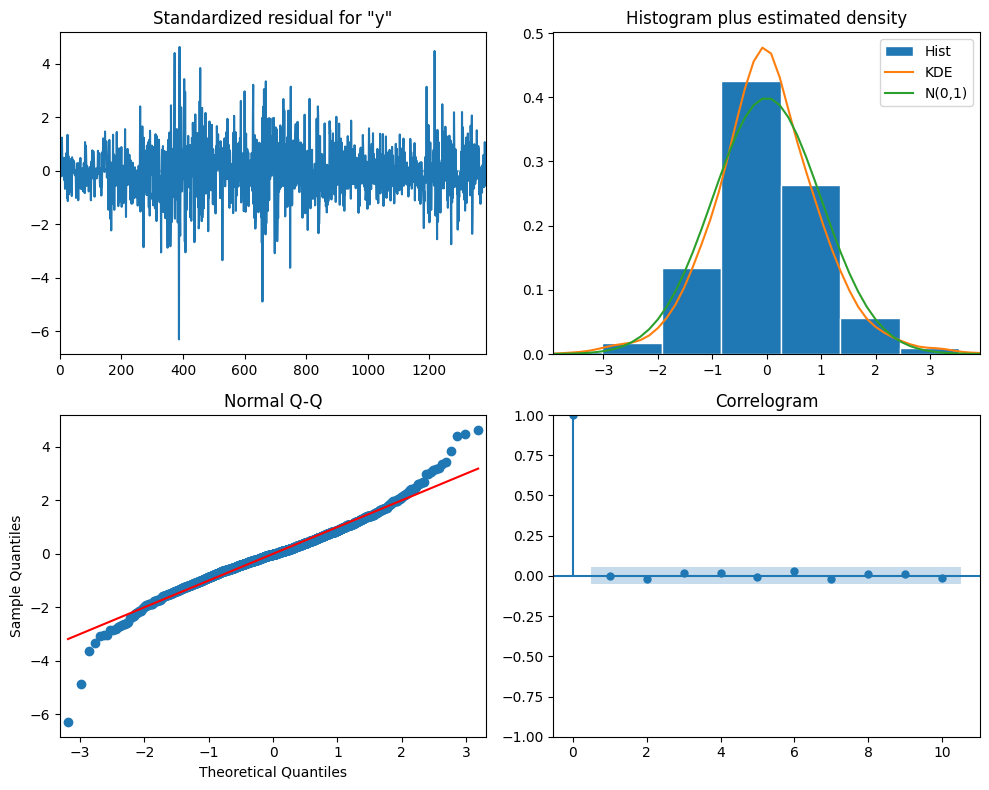

In [16]:
# Wbudowana funkcja do podstowej diagnostyki modelu
model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()


Mean: -0.014244659164919729, Standard Deviation: 6.1073208689698815
Skewness: 0.17206651633428455
Kurtosis: 0.7263184680866739
Kolmogorov-Smirnov test: statistic=0.030381223837917193, p-value=0.1516366944523967
Shapiro-Wilk test: statistic=0.9927433933162518, p-value=2.530717274594027e-06
Cramér-von Mises test: statistic=0.38824728227203925, p-value=0.07760392905904445

Wnioski z testów statystycznych:
Kolmogorov-Smirnov test wskazuje, że dane mogą pochodzić z rozkładu normalnego.
Shapiro-Wilk test wskazuje, że dane nie pochodzą z rozkładu normalnego.
Cramér-von Mises test wskazuje, że dane mogą pochodzić z rozkładu normalnego.


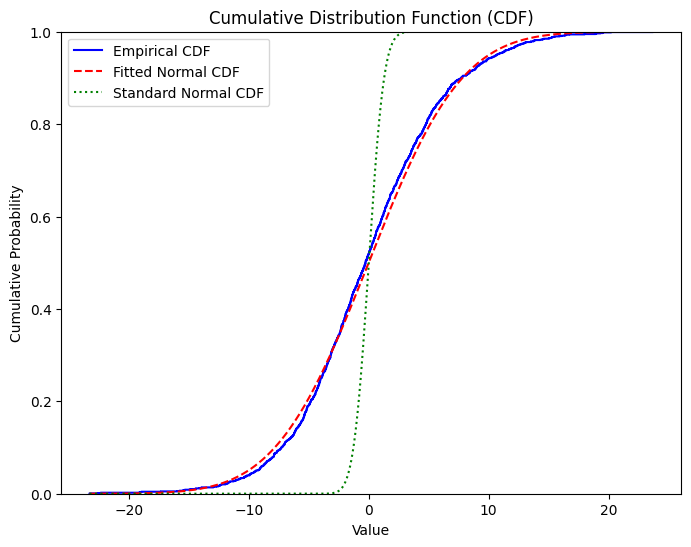

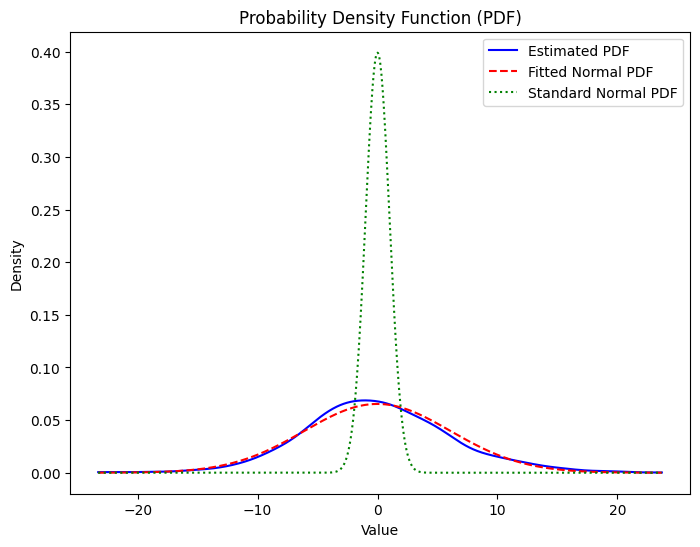

<Figure size 800x600 with 0 Axes>

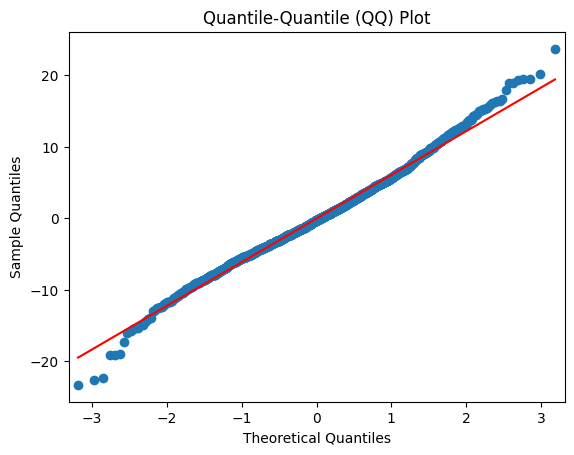

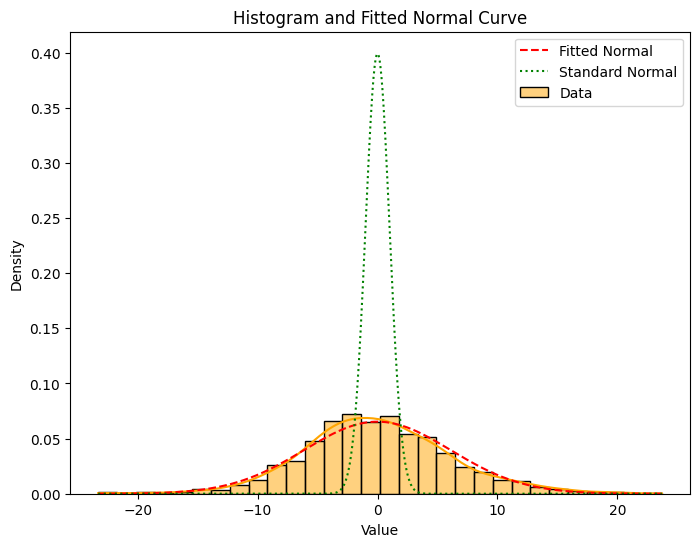

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kstest, shapiro, kurtosis, skew, gaussian_kde
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import cramervonmises

def analyze_time_series(data):
    """
    Analyzes a time series dataset and generates the following:
    - Cumulative distribution function (CDF)
    - Probability density function (PDF)
    - Quantile-Quantile (QQ) plot
    - Skewness and kurtosis
    - Normality tests: Kolmogorov-Smirnov and Shapiro-Wilk

    Parameters:
        data (array-like): Input time series data

    Returns:
        None
    """
    # Ensure the input is a numpy array
    data = np.asarray(data)

    # Basic descriptive statistics
    mean = np.mean(data)
    std_dev = np.std(data)
    print(f"Mean: {mean}, Standard Deviation: {std_dev}")

    # Skewness and kurtosis
    skewness = skew(data)
    kurt = kurtosis(data, fisher=True)  # Fisher=True gives excess kurtosis
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurt}")

    # Kolmogorov-Smirnov test
    ks_stat, ks_p_value = kstest(data, 'norm', args=(mean, std_dev))
    print(f"Kolmogorov-Smirnov test: statistic={ks_stat}, p-value={ks_p_value}")

    
    # Shapiro-Wilk test
    sw_stat, sw_p_value = shapiro(data)
    print(f"Shapiro-Wilk test: statistic={sw_stat}, p-value={sw_p_value}")

    # Cramér-von Mises test
    cvm_result = cramervonmises(data, 'norm', args=(mean, std_dev))
    print(f"Cramér-von Mises test: statistic={cvm_result.statistic}, p-value={cvm_result.pvalue}")

    # Wnioski z testów
    print("\nWnioski z testów statystycznych:")
    if ks_p_value < 0.05:
        print("Kolmogorov-Smirnov test wskazuje, że dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Kolmogorov-Smirnov test wskazuje, że dane mogą pochodzić z rozkładu normalnego.")

    if sw_p_value < 0.05:
        print("Shapiro-Wilk test wskazuje, że dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Shapiro-Wilk test wskazuje, że dane mogą pochodzić z rozkładu normalnego.")

    if cvm_result.pvalue < 0.05:
        print("Cramér-von Mises test wskazuje, że dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Cramér-von Mises test wskazuje, że dane mogą pochodzić z rozkładu normalnego.")

    # Plot the cumulative distribution function (CDF)
    plt.figure(figsize=(8, 6))
    sns.ecdfplot(data, label="Empirical CDF", color='blue')
    x = np.linspace(min(data), max(data), 1000)
    plt.plot(x, norm.cdf(x, loc=mean, scale=std_dev), label="Fitted Normal CDF", color='red', linestyle='--')
    plt.plot(x, norm.cdf(x), label="Standard Normal CDF", color='green', linestyle=':')
    plt.title("Cumulative Distribution Function (CDF)")
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.show()

    # Plot the probability density function (PDF)
    plt.figure(figsize=(8, 6))
    density = gaussian_kde(data)
    plt.plot(x, density(x), label="Estimated PDF", color='blue')
    plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), label="Fitted Normal PDF", color='red', linestyle='--')
    plt.plot(x, norm.pdf(x), label="Standard Normal PDF", color='green', linestyle=':')
    plt.title("Probability Density Function (PDF)")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Quantile-Quantile (QQ) plot
    plt.figure(figsize=(8, 6))
    qqplot(data, line='s')
    plt.title("Quantile-Quantile (QQ) Plot")
    plt.show()

    # Histogram with fitted normal curve
    plt.figure(figsize=(8, 6))
    sns.histplot(data, kde=True, stat="density", color='orange', bins=30, label="Data")
    plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), label="Fitted Normal", color='red', linestyle='--')
    plt.plot(x, norm.pdf(x), label="Standard Normal", color='green', linestyle=':')
    plt.title("Histogram and Fitted Normal Curve")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Example usage (replace with your time series data)
time_series_data = residual  # Example: Normally distributed data
analyze_time_series(time_series_data)


In [32]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(time_series):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity of a time series.

    Parameters:
        time_series (array-like): Input time series data.

    Returns:
        None
    """
    # Ensure the input is a numpy array
    time_series = np.asarray(time_series)

    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')

    # Extract results
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    # Print results
    print("Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"\t{key}: {value}")

    # Interpret results
    if p_value < 0.05:
        print("\nThe test rejects the null hypothesis (data is stationary).")
    else:
        print("\nThe test fails to reject the null hypothesis (data is non-stationary).")

# Example usage (replace with your time series data)
time_series_data = residual  # Example: Normally distributed data
adf_test(time_series_data)


Augmented Dickey-Fuller Test Results:
ADF Statistic: -11.157726658111313
p-value: 2.8382126309478953e-20
Critical Values:
	1%: -3.435125201816299
	5%: -2.863648897432019
	10%: -2.5678927750554617

The test rejects the null hypothesis (data is stationary).


T-test dla średniej reszt: T-stat = -0.00, p-value = 1.0000


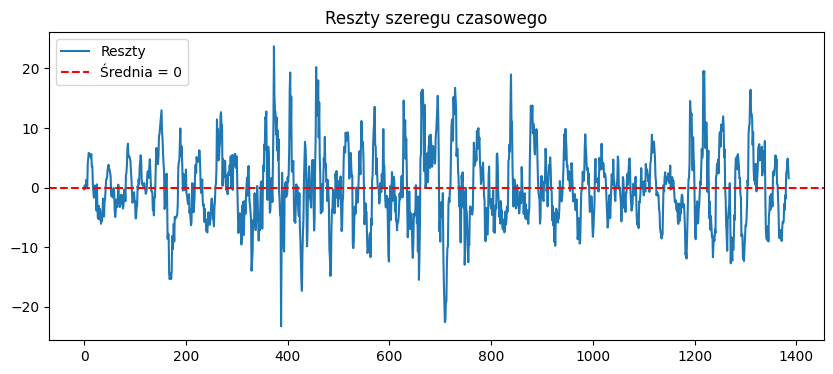

Modified Levene Test: stat = 0.20, p-value = 0.6548
ARCH Test: stat = 632.19, p-value = 0.0000


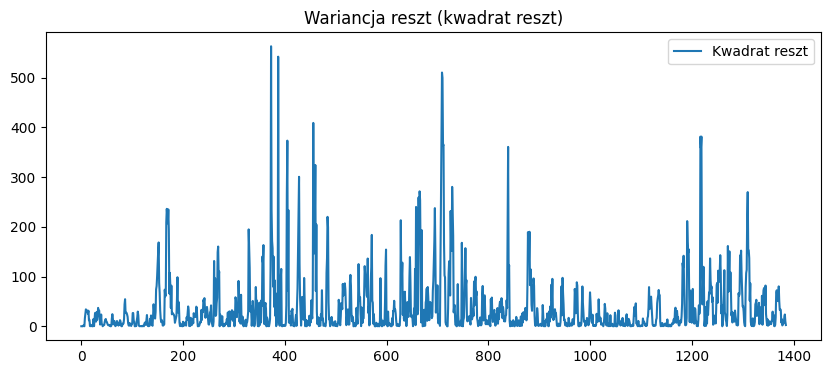

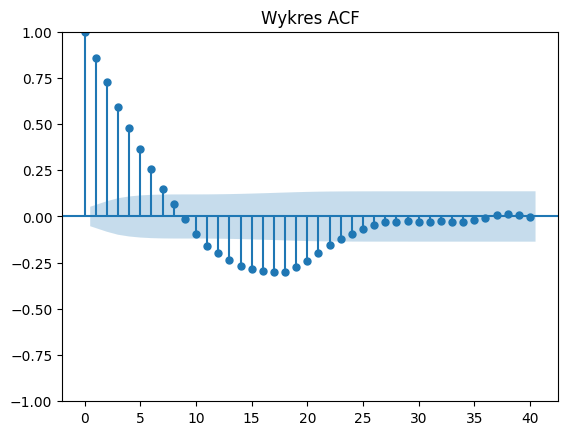

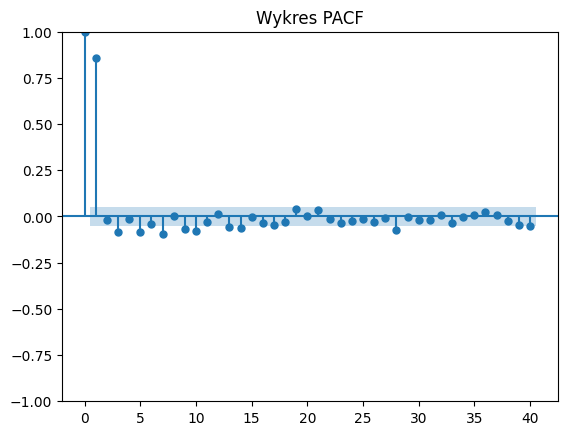

AttributeError: 'str' object has no attribute 'values'

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy.stats import ttest_1samp, levene

# Funkcja sprawdzająca warunki dla szeregu czasowego
def check_time_series_assumptions(series):
    # Sprawdź założenie dot. średniej
    residuals = series - np.mean(series)
    
    # T-test dla średniej reszt
    t_stat, p_value_t = ttest_1samp(residuals, 0)
    print(f"T-test dla średniej reszt: T-stat = {t_stat:.2f}, p-value = {p_value_t:.4f}")

    # Wykres reszt
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Reszty")
    plt.axhline(0, color='red', linestyle='--', label="Średnia = 0")
    plt.title("Reszty szeregu czasowego")
    plt.legend()
    plt.show()

    # Sprawdź założenie dot. wariancji
    # Modified Levene Test
    mid = len(series) // 2
    stat_levene, p_value_levene = levene(series[:mid], series[mid:])
    print(f"Modified Levene Test: stat = {stat_levene:.2f}, p-value = {p_value_levene:.4f}")

    # ARCH Test
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    print(f"ARCH Test: stat = {arch_stat:.2f}, p-value = {arch_p_value:.4f}")

    # Wykres reszt dla wariancji
    plt.figure(figsize=(10, 4))
    plt.plot(residuals**2, label="Kwadrat reszt")
    plt.title("Wariancja reszt (kwadrat reszt)")
    plt.legend()
    plt.show()

    # Sprawdź założenie dot. niezależności
    # Wykres ACF i PACF
    sm.graphics.tsa.plot_acf(residuals, lags=40, title="Wykres ACF")
    sm.graphics.tsa.plot_pacf(residuals, lags=40, title="Wykres PACF")
    plt.show()

    # Test Ljunga-Boxa
    ljung_stat, ljung_p_value = acorr_ljungbox(residuals, lags=[10])
    print(f"Ljung-Box Test (lag=10): stat = {ljung_stat.values[0]:.2f}, p-value = {ljung_p_value.values[0]:.4f}")

# Przykład użycia
if __name__ == "__main__":
    # Generowanie przykładowego szeregu czasowego (biały szum)

    time_series = residual

    # Sprawdzanie założeń dla szeregu czasowego
    check_time_series_assumptions(time_series)